# Lab 6: replicate spatial accessibility

In this lab, you will choose **your own study area** to measure spatial accessibility to hospitals. The focus of this lab is to let you conduct an accessibility study **from scratch**, starting from data acquisition to accessibility measurement. <br>
The size of analysis is recommended to a county, given the analysis time. For example, you can investigate your home county. The data source for this lab is as below. 

* Supply: <a href=https://hifld-geoplatform.opendata.arcgis.com/> Homeland Infrastructure Foundation-Level Data (HIFLD) </a> - <a href=https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::hospitals-1/>Hospitals</a>.
* Demand: US Census Bureau - <a href="https://data.census.gov/cedsci/table?q=population">Decennial Census - Race </a>
* Geographical Area of the reference: <a href=https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html>Topologically Integrated Geographic Encoding and Referencing (TIGER) data </a>

The example below aims to measure hospital accessibility in Harris County, Texas. You can follow the instruction or come up with your own study area. 


In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing
### 1. (1.5 point) Demand-related data
#### 1.1. (0.5 point) Obtain geographical area of the reference
**1.1.1.** Click <a href=https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html>this link</a> to obtain census tract data from TIGER file.  <br>
**1.1.2.** Load the shapefile as a GeoDataFrame with the name of `tract`. <br>
**1.1.3.** Remove unnecessary information from the file and maintain only two columns (`GEOID` and `geometry`). <br>
**1.1.4.** Visit <a href="https://www.nrcs.usda.gov/wps/portal/nrcs/detail/tx/technical/dma/rwa/?cid=nrcs143_013697"> this website </a> and find the FIPS code of the county that you focus on. <br>
**1.1.5.** Slice the dataframe so that it only stores values associated with the current study area. 

**From this**
![](./data/fig1_1.jpg)

**to this**
![](./data/fig1_2.jpg)


In [2]:
# Your code here
tract = gpd.read_file('./data/tl_2020_48_tract/tl_2020_48_tract.shp')
tract = tract[['GEOID', 'geometry']]
tract = tract.loc[tract['GEOID'].str.startswith('48201')]
tract.head()

,GEOID,geometry
88,48201233105,"POLYGON ((-95.16994 29.79037, -95.16731 29.790..."
89,48201252201,"POLYGON ((-95.17530 29.83223, -95.17486 29.832..."
90,48201232404,"POLYGON ((-95.21099 29.83258, -95.20947 29.833..."
91,48201232203,"POLYGON ((-95.26868 29.93338, -95.26861 29.933..."
92,48201232306,"POLYGON ((-95.21416 29.85010, -95.21276 29.850..."


In [3]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(tract) == gpd.GeoDataFrame
assert ('GEOID' in tract.columns) & ('geometry' in tract.columns)
assert ('STATEFP' not in tract.columns) & ('NAME' not in tract.columns)

print('Success!')

Success!


#### 1.2. (0.5 point) Obtain population data

**1.2.1.** Visit <a href="https://data.census.gov/cedsci/table?q=population">this website</a> and find the appropriate data according to your study area. <br>
**1.2.2.** Open the data as DataFrame with the variable name `pop`, and format the data as shown below. 

**From this**
![](./data/fig2_1.jpg)

**to this**
![](./data/fig2_2.jpg)

**1.2.3.** This will require the following progress. 
* Load the first row of the CSV as the header, but remove the first row of the data. 
* Select only the necessary information (`GEO_ID` and `P1_001N` columns).
* Rename the `P1_001N` column to `pop` with <a href=https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html>`df.rename()`</a>.
* From the `GEO_ID` column, remove the unnecessary digits (i.e., 1400000US) with <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html">`df.apply(lambda x:)`</a>. 
* Change the datatype of `pop` column from `str` to `int` (Currently, the population data is stored as a string) with <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.astype.html">`Series.astype()`</a>. 


In [4]:
# Your code here
pop = pd.read_csv('./data/DECENNIALPL2020.P1_2022-03-27T152321/DECENNIALPL2020.P1_data_with_overlays_2021-11-26T190228.csv',)
pop = pop.loc[1:]
pop = pop[['GEO_ID', 'P1_001N']]
pop = pop.rename(columns={'P1_001N': 'pop'})
pop['GEO_ID'] = pop.apply(lambda x:x['GEO_ID'][9:], axis=1)
pop['pop'] = pop['pop'].astype(int)
pop.head()

,GEO_ID,pop
1,48201100001,6543
2,48201210400,4167
3,48201210500,5370
4,48201210600,5165
5,48201210700,2293


In [5]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(pop) == pd.DataFrame
assert len(pop.at[1, 'GEO_ID']) == 11
assert ('GEO_ID' in pop.columns) & ('pop' in pop.columns)
assert pop['pop'].dtype == int

print('Success!')

Success!


#### 1.3. (0.5 point) Create `demand` GeoDataFrame based on `tract` GeoDataFrame and `pop` DataFrame. 
**1.3.1.** Investigate the two dataframe and see which column has the same data. <br>
**1.3.2.** Merge `tract` GeoDataFrame and `pop` DataFrame based on the columns you found with <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html>gpd.merge()</a> and name the resulted GeoDataFrame as `demand`. <br>
**1.3.3.** Change the coordinate system of the GeoDataFrame to "NAD83 / Conus Albers (epsg:5070)".<br>
**1.3.4.** Drop unnecessary `GEO_ID` column. The result should look like the below. <br>

![](./data/fig2_3.jpg)

In [6]:
# Your code here
demand = tract.merge(pop, left_on='GEOID', right_on='GEO_ID')
demand = demand.drop(columns=['GEO_ID'])
demand = demand.to_crs(epsg=5070)
demand.head()

,GEOID,geometry,pop
0,48201233105,"POLYGON ((80205.494 746468.105, 80459.750 7464...",3734
1,48201252201,"POLYGON ((79647.402 751105.707, 79689.899 7511...",4838
2,48201232404,"POLYGON ((76200.692 751116.046, 76346.604 7511...",3652
3,48201232203,"POLYGON ((70542.932 762253.345, 70549.541 7622...",5924
4,48201232306,"POLYGON ((75877.706 753056.961, 76013.176 7530...",3644


In [7]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(demand) == gpd.GeoDataFrame
assert ('GEOID' in demand.columns) & ('pop' in demand.columns)
assert demand['pop'].dtype == int
assert demand.crs.name == 'NAD83 / Conus Albers'

print('Success!')

Success!


### 2. (1 point) Supply-related data

**2.1.** Visit <a href="https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::hospitals-1/explore">HIFLD website</a> and download the hospital data as shapefile to your local directory. <br>
**2.2.** Load the downloaded hospitals as GeoDataFrame with the name of `supply`. <br>
**2.3.** Change the coordinate system of `supply` to "NAD83 / Conus Albers (epsg:5070)", in order to match its dataframe with `demand` GeoDataFrame. <br>
**2.4.** Select only the records in `supply` GeoDataFrame within the geometry of `demand`. <br>
**2.5.** The downloaded data has duplicates so remove the duplicates based on the `ID` column by using <a href=https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html>`df.drop_duplicates()`</a>. <br>
**2.6.** Make `supply` GeoDataFrame only has the columns (`ID`, `NAME`, `CITY`, `ZIP`, `BEDS`, `geometry`). <br>
**2.7.** The data uses `-999` in `BEDS` column for the missing values. Remove the entire row if it has the missing value of `BEDS`.<br>
**2.8.** Reset the index of the current GeoDataFrame with <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html">`gdf.reset_index()`</a> function. <br>

The result should look like the below. 
![](./data/fig2_4.jpg)

In [9]:
# Your code here
supply = gpd.read_file('./data/Hospitals/Hospitals.shp')
supply = supply.to_crs(epsg=5070)
supply = supply.loc[supply.geometry.within(demand.geometry.unary_union)]
supply = supply.drop_duplicates(subset=['ID'])
supply = supply[['ID', 'NAME', 'CITY', 'ZIP', 'BEDS', 'geometry']]
supply = supply.loc[supply['BEDS'] != -999]
supply = supply.reset_index(drop=True)
supply.head()

,ID,NAME,CITY,ZIP,BEDS,geometry
0,0004677521,HOUSTON METHODIST BAYTOWN HOSPITAL,BAYTOWN,77521,205.0,POINT (98611.340 744289.745)
1,0006177401,MEMORIAL HERMANN ORTHOPEDIC AND SPINE HOSPITAL,BELLAIRE,77401,64.0,POINT (52103.134 738882.708)
2,0026377030,CHI ST LUKES HEALTH BAYLOR COLLEGE OF MEDICINE...,GRANBURY,77030,864.0,POINT (57991.445 737135.318)
3,0029877091,MEMORIAL HERMANN NORTHEAST HOSPITAL,HUMBLE,77338,255.0,POINT (69772.295 769142.888)
4,0031677494,MEMORIAL HERMANN KATY HOSPITAL,KATY,77494,208.0,POINT (20654.913 745801.658)


In [10]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(supply) == gpd.GeoDataFrame
assert supply.crs.name == 'NAD83 / Conus Albers'
assert supply.shape == (115, 6)
assert supply.loc[supply['BEDS'] == 999].shape[0] == 0

print('Success!')

Success!


### 3. (0.5 point) Mobility-related data

Examine the following code and change the location according to your study area. 

```python
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 10:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network


# Obtain OSM Network in Harris County, Texas
G = ox.graph_from_place('Harris County, TX, USA', network_type='drive', simplify=True)

# Simplify Graph: Remove edges
for u, v, data in G.copy().edges(data=True):
    if data['highway'] not in ['motorway', 'motorway_link', 
                               'trunk', 'trunk_link',
                               'primary', 'primary_link', 
# This line is commented to make the future process faster. 
# If your study area is small and doesn't have enough road network, please uncomment the following line. 
                               'secondary', 'secondary_link'  
                              ]:
        G.remove_edge(u, v)
        
# Simplify Graph: Remove nodes
G.remove_nodes_from(list(nx.isolates(G)))

G = ox.project_graph(G, to_crs='epsg:5070')
G = remove_uncenessary_nodes(G)

ox.plot_graph(G)
```


Removed 1588 nodes (0.1280%) from the OSMNX network
Number of nodes: 12409
Number of edges: 16894


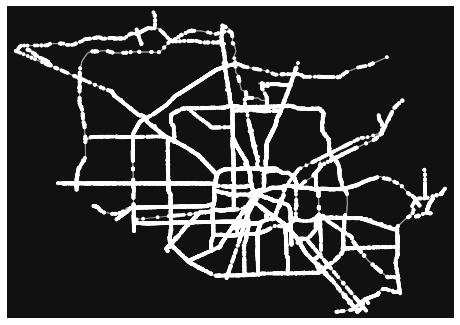

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 10:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network


# Obtain OSM Network in Harris County, Texas
G = ox.graph_from_place('Harris County, TX, USA', network_type='drive', simplify=True)

# Simplify Graph: Remove edges
for u, v, data in G.copy().edges(data=True):
    if data['highway'] not in ['motorway', 'motorway_link', 
                               'trunk', 'trunk_link',
                               'primary', 'primary_link', 
# This line is commented to make the future process faster. 
# If your study area is small and doesn't have enough road network, please uncomment the following line. 
#                                'secondary', 'secondary_link'  
                              ]:
        G.remove_edge(u, v)
        
# Simplify Graph: Remove nodes
G.remove_nodes_from(list(nx.isolates(G)))

G = ox.project_graph(G, to_crs='epsg:5070')
G = remove_uncenessary_nodes(G)

ox.plot_graph(G)

## Replicate Spatial accessiblity study

### 4. (1 ponit) Find the nearest OSM node from given locations
**4.1.** Examine the following function and make an appropriate change if necessary. <br>
**4.2.** Calculate the nearest osm node of `supply` and `demand` GeoDataFrame by calling `find_nearest_osm` function. 

```python
    
def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf
```

In [12]:
def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf

# Your code here
supply = find_nearest_osm(G, supply)
demand = find_nearest_osm(G, demand)

100%|██████████| 1115/1115 [01:24<00:00, 13.16it/s]


In [13]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(supply) == gpd.GeoDataFrame
assert type(demand) == gpd.GeoDataFrame
assert 'nearest_osm' in supply.columns
assert 'nearest_osm' in demand.columns

print('Success!')

Success!


### 5. (1 point) Measure spatial accessibility to hospitals by reusing the functions. 

**5.1.** Examine the following function and make an appropriate change if necessary. <br>
**5.2.** Measure spatial accessibility to hospitals in your own study area by calling `step1_2SFCA` and `step2_2SFCA` function, sequentially. <br>
**5.3.** Find an appropriate threshold travel distance (`threshold`) within your study area. This value can be determined by examining the accessibility measures. They should not have more than 25% of 0 value but create the distribution of accessibility measures more than 5 unique values. <br>

```python
def extract_edges_nodes_from_networkx(network):
    nodes, edges = ox.graph_to_gdfs(network, nodes=True, edges=True, node_geometry=True)
    
    return nodes, edges


def step1_2SFCA(supply, supply_attr, demand, demand_attr, mobility, threshold):
    """
    Input: 
    - supply (GeoDataFrame): stores locations and attributes of supply 
    - supply_attr (str): the column of `supply` to be used for the analysis
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - demand_attr (str): the column of `demand` to be used for the analysis
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - supply_ (GeoDataFrame): 
      a copy of supply and it stores supply-to-demand ratio of each supply at `ratio` column
    """
    
    # Extract the nodes and edges of the network dataset for the future analysis. 
    nodes, edges = extract_edges_nodes_from_networkx(mobility)
    
    supply_ = supply.copy(deep=True)
    supply_['ratio'] = 0
    
    for i in trange(supply.shape[0]):
    
        # Create a catchment area from a given location
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, supply.loc[i, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:5070")

        # Calculate the population within the catchment area
        temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), demand_attr].sum()

        # Calculate the number of hospital beds in each hospital
        temp_supply = supply.loc[i, supply_attr]

        # Calculate the number of hospital beds available for 100,000 people 
        supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000
        
    supply_['ratio'].replace(np.inf, 0, inplace=True)
    
    return supply_


def step2_2SFCA(result_step1, demand, mobility, threshold):
    """
    Input: 
    - result_step1 (GeoDataFrame): stores locations and 'ratio' attribute that resulted in step1 
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - demand_ (GeoDataFrame): 
      a copy of demand and it stores the final accessibility measures of each demand location at `ratio` column
    """
    
    # Extract the nodes and edges of the network dataset for the future analysis. 
    nodes, edges = extract_edges_nodes_from_networkx(mobility)
    
    demand_ = demand.copy(deep=True)
    demand_['access'] = 0

    for j in trange(demand.shape[0]):
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, demand.loc[j, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:5070")

        accum_ratio = result_step1.loc[result_step1['geometry'].within(access_nodes[0]), 'ratio'].sum()
        demand_.at[j, 'access'] = accum_ratio

    return demand_

```

In [14]:
def extract_edges_nodes_from_networkx(network):
    nodes, edges = ox.graph_to_gdfs(network, nodes=True, edges=True, node_geometry=True)
    
    return nodes, edges


def step1_2SFCA(supply, supply_attr, demand, demand_attr, mobility, threshold):
    """
    Input: 
    - supply (GeoDataFrame): stores locations and attributes of supply 
    - supply_attr (str): the column of `supply` to be used for the analysis
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - demand_attr (str): the column of `demand` to be used for the analysis
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - supply_ (GeoDataFrame): 
      a copy of supply and it stores supply-to-demand ratio of each supply at `ratio` column
    """
    
    # Extract the nodes and edges of the network dataset for the future analysis. 
    nodes, edges = extract_edges_nodes_from_networkx(mobility)
    
    supply_ = supply.copy(deep=True)
    supply_['ratio'] = 0
    
    for i in trange(supply.shape[0]):
    
        # Create a catchment area from a given location
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, supply.loc[i, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:5070")

        # Calculate the population within the catchment area
        temp_demand = demand.loc[demand['geometry'].centroid.within(access_nodes[0]), demand_attr].sum()

        # Calculate the number of hospital beds in each hospital
        temp_supply = supply.loc[i, supply_attr]

        # Calculate the number of hospital beds available for 100,000 people 
        supply_.at[i, 'ratio'] = temp_supply / temp_demand * 100000
        
    supply_['ratio'].replace(np.inf, 0, inplace=True)
    
    return supply_


def step2_2SFCA(result_step1, demand, mobility, threshold):
    """
    Input: 
    - result_step1 (GeoDataFrame): stores locations and 'ratio' attribute that resulted in step1 
    - demand (GeoDataFrame): stores locations and attributes of demand 
    - mobility (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - threshold (int): threshold travel distance
    
    Output:
    - demand_ (GeoDataFrame): 
      a copy of demand and it stores the final accessibility measures of each demand location at `ratio` column
    """
    
    # Extract the nodes and edges of the network dataset for the future analysis. 
    nodes, edges = extract_edges_nodes_from_networkx(mobility)
    
    demand_ = demand.copy(deep=True)
    demand_['access'] = 0

    for j in trange(demand.shape[0]):
        temp_nodes = nx.single_source_dijkstra_path_length(mobility, demand.loc[j, 'nearest_osm'], threshold, weight='length')
        access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
        access_nodes = gpd.GeoSeries(access_nodes.unary_union.convex_hull, crs="EPSG:5070")

        accum_ratio = result_step1.loc[result_step1['geometry'].within(access_nodes[0]), 'ratio'].sum()
        demand_.at[j, 'access'] = accum_ratio

    return demand_


In [15]:
# Your code here
dist = 15000

step1 = step1_2SFCA(supply, 'BEDS', demand, 'pop', G, dist)
step2 = step2_2SFCA(step1, demand, G, dist)


100%|██████████| 1115/1115 [00:11<00:00, 97.28it/s] 


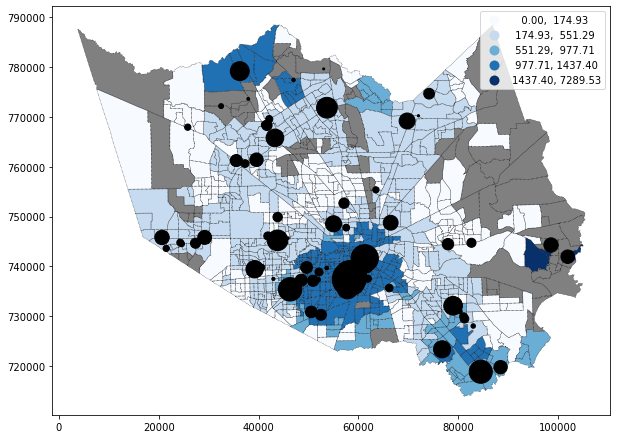

Success!


In [16]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert len(step2['access'].unique()) > 5
assert step2.loc[step2['access'] == 0].shape[0] / step2.shape[0] < 0.25

fig, ax = plt.subplots(figsize=(10,10))

step1.plot(markersize='BEDS', ax=ax, zorder=2, color='black')
step2.plot('access', ax=ax, legend=True, cmap='Blues', scheme='FisherJenks', zorder=1)
step2.loc[step2['access'] == 0].plot(ax=ax, color='grey', zorder=1)
step2.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=2)

plt.show()

print('Success!')